In [1]:
using RxInfer, Random, StatsPlots, BenchmarkTools, LinearAlgebra, Profile, PProf

In [2]:
Threads.nthreads()

4

In [3]:
Threads.nthreads(:interactive)

4

In [4]:
module Parallel
	include("../parallel.jl")
end

Main.Parallel

In [5]:
n = 100  # Number of coin flips
p = 0.75 # Bias of a coin

distribution = Bernoulli(p)
dataset      = float.(rand(Bernoulli(p), n))
prior = Beta(2.0, 6.0)

Beta{Float64}(α=2.0, β=6.0)

In [6]:
@model function coin_model(n, prior, prod_strategy, pipeline, meta)

    y = datavar(Float64, n)
	θ = randomvar() where { prod_strategy = prod_strategy }

    θ ~ prior

    for i in 1:n
        y[i] ~ Bernoulli(θ) where { pipeline = pipeline, meta = meta  }
    end

end

In [7]:
struct MyCustomRule
	size::Int
end

In [8]:
@rule Bernoulli(:p, Marginalisation) (q_out::PointMass, meta::MyCustomRule) = begin
    @logscale -log(2)
    r = mean(q_out)
	s = det(inv(rand(meta.size, meta.size))) / 10^8
    return Beta(one(r) + r, 2one(r) - r)
end

In [9]:
function run_test(prod_strategy, pipeline, size)
	b = @benchmark infer(
	    model = coin_model(length(dataset), prior, $prod_strategy, $pipeline, MyCustomRule($size)),
	    data  = (y = dataset, ),
		callbacks = (after_iteration = Parallel.after_iteration_cb, ),
	) seconds = 20
	println("Samples: $(length(b.times))")

    return minimum(b.times)
end

run_test (generic function with 1 method)

In [10]:
sizes = [2, 10, 50, 100, 500]
rule_time = Vector{Float64}(undef, length(sizes))
time_s = Vector{Float64}(undef, length(sizes))
time_p = Vector{Float64}(undef, length(sizes))
time_ip = Vector{Float64}(undef, length(sizes))
time_p_blocking = Vector{Float64}(undef, length(sizes))
time_p_donefirst = Vector{Float64}(undef, length(sizes))
time_blocking = Vector{Float64}(undef, length(sizes));

In [ ]:
for i in eachindex(sizes)
    println("Evaluating coin toss model with matrix size: $(sizes[i]) and samples: $n")

    b = @benchmark @call_rule Bernoulli(:p, Marginalisation) (q_out = PointMass(1), meta = MyCustomRule(sizes[$i]))
    rule_time[i] = minimum(b.times)

    time_s[i] = run_test(nothing, nothing, sizes[i])
    #time_p[i] = run_test(nothing, Parallel.ThreadsPipelineStage(), sizes[i])
    time_ip[i] = run_test(nothing, Parallel.IThreadsPipelineStage(), sizes[i])
    time_p_blocking[i] = run_test(Parallel.CustomProdStrategy(Parallel.blocking_parallel_prod), Parallel.IThreadsPipelineStage(), sizes[i])
    time_p_donefirst[i] = run_test(Parallel.CustomProdStrategy(Parallel.done_first_parallel_prod), Parallel.IThreadsPipelineStage(), sizes[i])
end

In [12]:
rel_speed_p = time_s ./ time_p
rel_speed_ip = time_s ./ time_ip
rel_speed_p_blocking = time_s ./ time_p_blocking
rel_speed_p_donefirst = time_s ./ time_p_donefirst
rule_time_ms = rule_time / 1000;

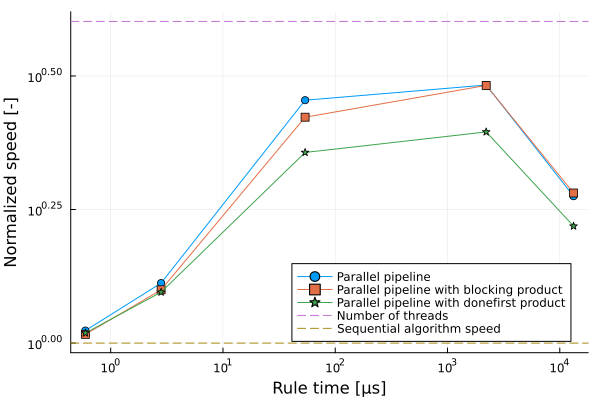

In [15]:
plot(xaxis=:log, yaxis=:log, legend=:bottomright, xlabel="Rule time [μs]", ylabel="Normalized speed [-]")
#plot!(rule_time_ms, rel_speed_p, markershape=:circle, label="Parallel pipeline")
plot!(rule_time_ms, rel_speed_ip, markershape=:circle, label="Parallel pipeline")
plot!(rule_time_ms, rel_speed_p_blocking, markershape=:rect, label="Parallel pipeline with blocking product")
plot!(rule_time_ms, rel_speed_p_donefirst, markershape=:star5, label="Parallel pipeline with donefirst product")
hline!([Threads.nthreads()], linestyle=:dash, label="Number of threads")
hline!([1], linestyle=:dash, label="Sequential algorithm speed")